In [1]:
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from __future__ import division
from IPython.core.debugger import set_trace

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
shoppings = pd.read_csv('./data/supermarket_data.csv')

In [3]:
shoppings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671914 entries, 0 to 671913
Data columns (total 8 columns):
SHOP_DATE     671914 non-null int64
SHOP_HOUR     671914 non-null int64
BASKET_ID     671914 non-null int64
CUST_CODE     671914 non-null object
STORE_CODE    671914 non-null object
PROD_CODE     671914 non-null object
QUANTITY      671914 non-null int64
SPEND         671914 non-null float64
dtypes: float64(1), int64(4), object(3)
memory usage: 41.0+ MB


In [4]:
shoppings['SHOP_DATE'] =  shoppings['SHOP_DATE'].apply(str)
shoppings['SHOP_DATE'] = pd.to_datetime(shoppings['SHOP_DATE'], format='%Y%m%d')
#shoppings['SHOP_TIME_DATE'] = shoppings['SHOP_DATE'] + pd.to_timedelta(shoppings['SHOP_HOUR'], unit='h')

### Which products are picked the most often?

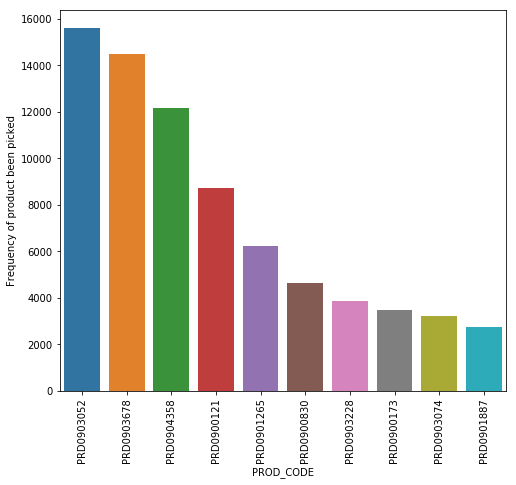

In [5]:
groupby_by_product = shoppings.groupby('PROD_CODE', as_index=False)

number_of_picked_by_products = groupby_by_product['BASKET_ID'].count()
most_picked_products = number_of_picked_by_products.sort_values('BASKET_ID', ascending=False)[:10]

plt.figure(figsize=(8, 7))
sns.barplot(data=most_picked_products, x='PROD_CODE', y='BASKET_ID', order=most_picked_products['PROD_CODE'])
plt.xticks(rotation=90)
plt.ylabel('Frequency of product been picked')
plt.show()

### Which products produce the most sales?

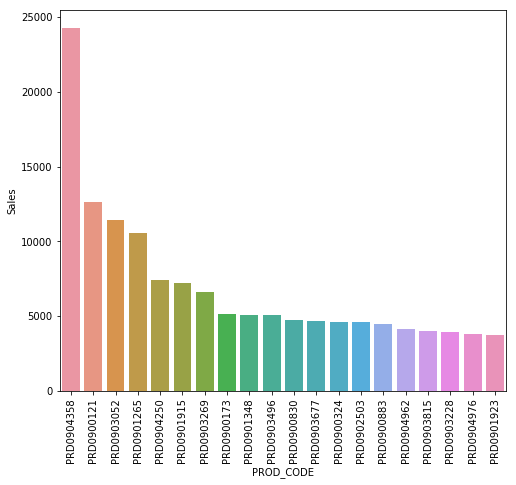

In [6]:
sales_by_products = groupby_by_product['SPEND'].sum()
top_sales = sales_by_products.sort_values('SPEND', ascending=False)[:20]

plt.figure(figsize=(8, 7))
sns.barplot(data=top_sales, x='PROD_CODE', y='SPEND', order=top_sales['PROD_CODE'])
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.show()

### For each product, How many  items have been sold for a day?

In [7]:
total_quantity_by_products = groupby_by_product.agg({
    'QUANTITY' : np.sum
})

days_duration_by_products = groupby_by_product.agg({
    'SHOP_DATE' : ['max', 'min']
}).assign(
    DAYS = lambda row: (row['SHOP_DATE']['max'] - row['SHOP_DATE']['min']).apply(lambda x: x.days)
).drop(columns=['SHOP_DATE'])
days_duration_by_products.columns = days_duration_by_products.columns.droplevel(1) 

number_items_sold_by_products = pd.merge(total_quantity_by_products, days_duration_by_products, on='PROD_CODE')
number_items_sold_by_products = number_items_sold_by_products.loc[ number_items_sold_by_products['DAYS']>0,:]
number_items_sold_by_products = number_items_sold_by_products.assign(
    ITEMS_SOLD_PER_DAY = lambda row: row['QUANTITY'] / row['DAYS'],
    ITEMS_SOLD_PER_WEEK = lambda row: row['QUANTITY'] / (row['DAYS'] / 7)
)



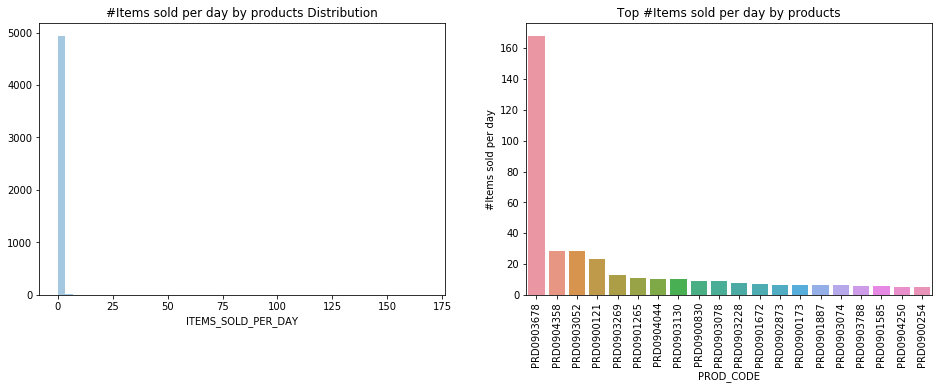

In [8]:
top_sold_per_day = number_items_sold_by_products.sort_values('ITEMS_SOLD_PER_DAY', ascending=False)[:20]

plt.figure(figsize=(16 ,5))
plt.subplot(121)
sns.distplot(number_items_sold_by_products['ITEMS_SOLD_PER_DAY'], kde=False)
plt.title("#Items sold per day by products Distribution")

plt.subplot(122)
sns.barplot(data=top_sold_per_day, x='PROD_CODE', y='ITEMS_SOLD_PER_DAY', order=top_sold_per_day['PROD_CODE'])
plt.xticks(rotation=90)
plt.ylabel('#Items sold per day')
plt.title('Top #Items sold per day by products')

plt.show()

### What day/time  are most of 'PRD0903678'   sold?

In [9]:
#PRD0903678
def map_to_weekday(x):
    if x == 0:
        return 'MON'
    elif x == 1:
        return 'TUE'
    elif x == 2:
        return 'WED'
    elif x == 3:
        return 'THU'
    elif x == 4:
        return 'FRI'
    elif x == 5:
        return 'SAT'
    else:
        return 'SUN'
    
def plot_product_total_qty(product_code):
    product_group = shoppings.groupby('PROD_CODE', as_index=False).filter(lambda x: x['PROD_CODE'].iloc[0] == product_code)
    product_group['WEEK_DAY'] = product_group['SHOP_DATE'].apply(lambda x: map_to_weekday(x.weekday()))                                   

    total_qty_by_day = product_group.groupby('WEEK_DAY', as_index=False)['QUANTITY'].sum()
    total_qty_by_time = product_group.groupby('SHOP_HOUR', as_index=False)['QUANTITY'].sum()
    total_qty_by_store = product_group.groupby('STORE_CODE', as_index=False)['QUANTITY'].sum()

    plt.figure(figsize=(20, 20))
    plt.subplot(221)
    sns.barplot(data=total_qty_by_day, x='WEEK_DAY', y='QUANTITY', order=['MON', 'TUE', 'WED','THU','FRI','SAT','SUN'])
    plt.ylabel('Total QUANTITY')

    plt.subplot(222)
    sns.barplot(data=total_qty_by_time, x='SHOP_HOUR', y='QUANTITY')
    plt.ylabel('Total QUANTITY')


    plt.subplot(223)
    sns.barplot(data=total_qty_by_store, x='STORE_CODE', y='QUANTITY')
    plt.ylabel('Total QUANTITY')
    plt.title('Total Quantity by Store')
    plt.show()
    plt.show()

### Top sales sold per day

In [10]:
#plot_product_total_qty('PRD0903678')

### Top sales product

In [11]:
#plot_product_total_qty('PRD0904358')

In [12]:
grouped = shoppings.groupby(['STORE_CODE', 'PROD_CODE'], as_index=False).agg({
    'QUANTITY' : np.sum,
    'SPEND' : np.sum
})

In [13]:
def plot_store(store_code):
    store = grouped.loc[grouped['STORE_CODE'] == store_code]
    top_quantity = store.sort_values('QUANTITY', ascending=False)[:20]
    top_sales = store.sort_values('SPEND', ascending=False)[:20]
    
    plt.figure(figsize=(16, 5))
    plt.gcf().suptitle(store_code)
    plt.title(store_code)
    plt.subplot(121)
    sns.barplot(data=top_quantity, x='PROD_CODE', y='QUANTITY', order=top_quantity['PROD_CODE'])
    plt.ylabel('Total Quantity')
    plt.title("Top #Items Sold by Product")
    plt.xticks(rotation=90)
    
    plt.subplot(122)
    sns.barplot(data=top_sales, x='PROD_CODE', y='SPEND', order=top_sales['PROD_CODE'])
    plt.ylabel('Total Salse')
    plt.title("Top Salse by products")
    plt.xticks(rotation=90)
    plt.show()

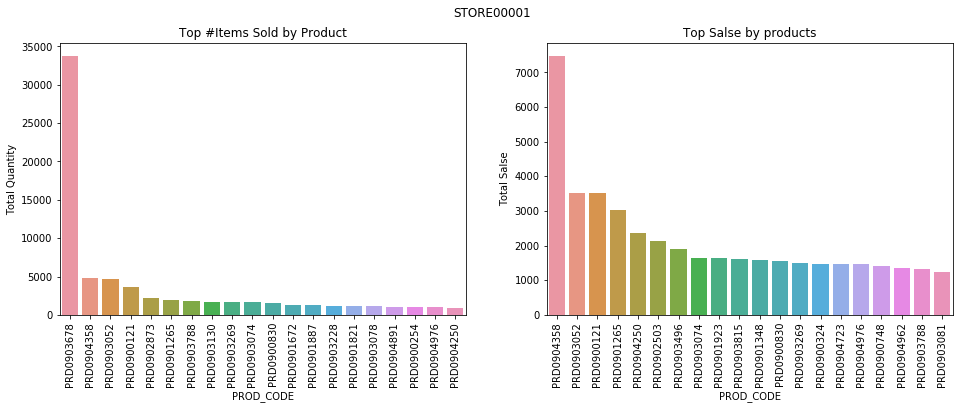

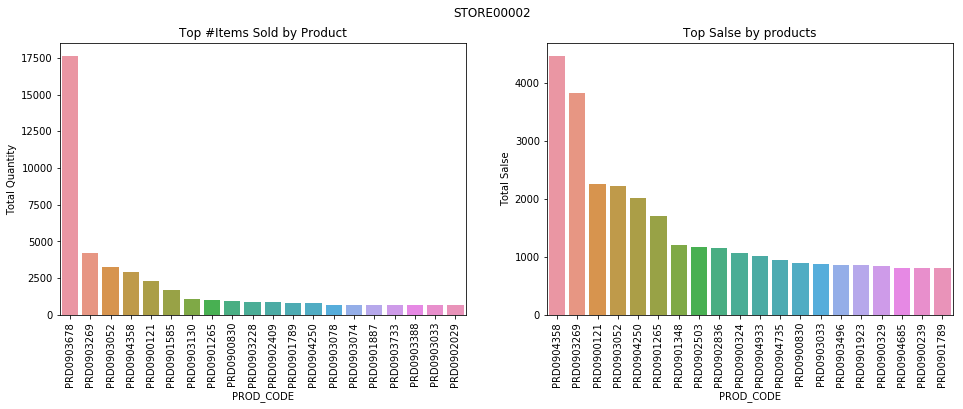

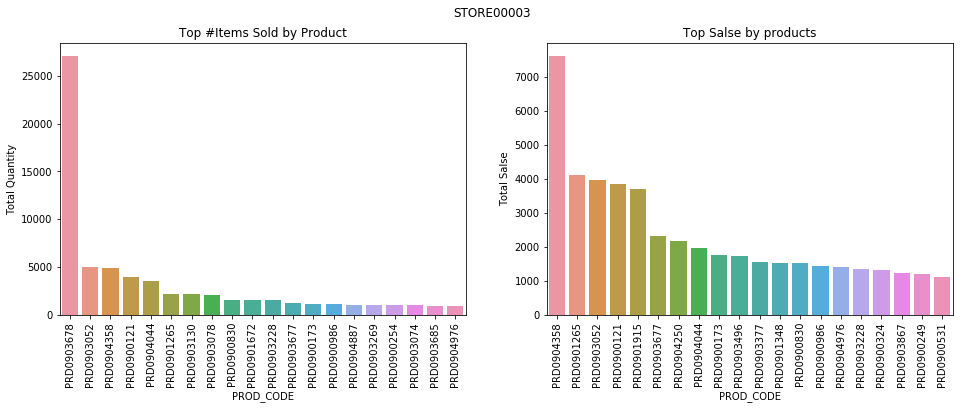

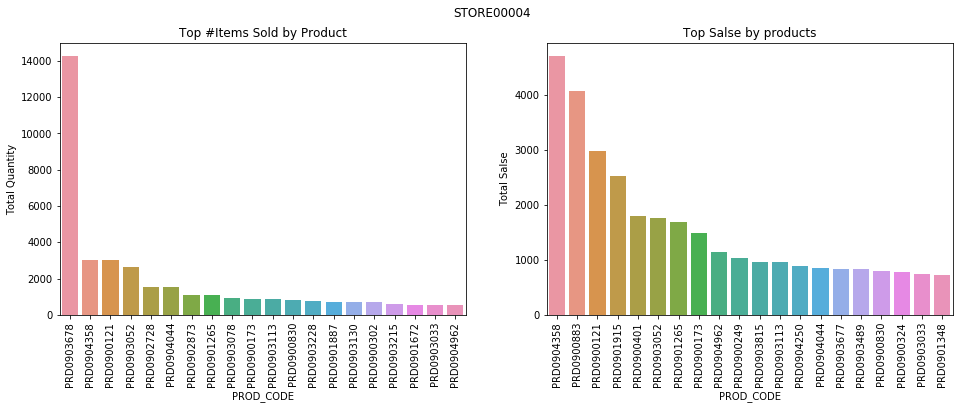

In [14]:
for store_code in shoppings['STORE_CODE'].unique():
    plot_store(store_code)

In [15]:
##PRD0903678, PRD0904358

### PRD0903678 analysis

In [16]:
top_sale_product_code = 'PRD0903678'
top_sale_product = shoppings.loc[shoppings['PROD_CODE'] == 'PRD0903678', :]

In [17]:
top_sale_product['WEEK_DAY'] = top_sale_product['SHOP_DATE'].apply(lambda x: map_to_weekday(x.weekday()))

In [18]:
def plot_top_product_by_time(store_code):
    week_day_order = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
    products = top_sale_product.loc[top_sale_product['STORE_CODE'] == store_code] 
    plt.figure(figsize=(16, 7))
    plt.gcf().suptitle(store_code)
    plt.subplot(121)
    plt.title(f"{top_sale_product_code} of {store_code} SHOP_HOUR distribution")
    sns.countplot(products['SHOP_HOUR'])
    plt.subplot(122)
    plt.title(f"{top_sale_product_code} of {store_code} WEEK_DAY distribution")
    sns.countplot(products['WEEK_DAY'], order=week_day_order)
    plt.show()

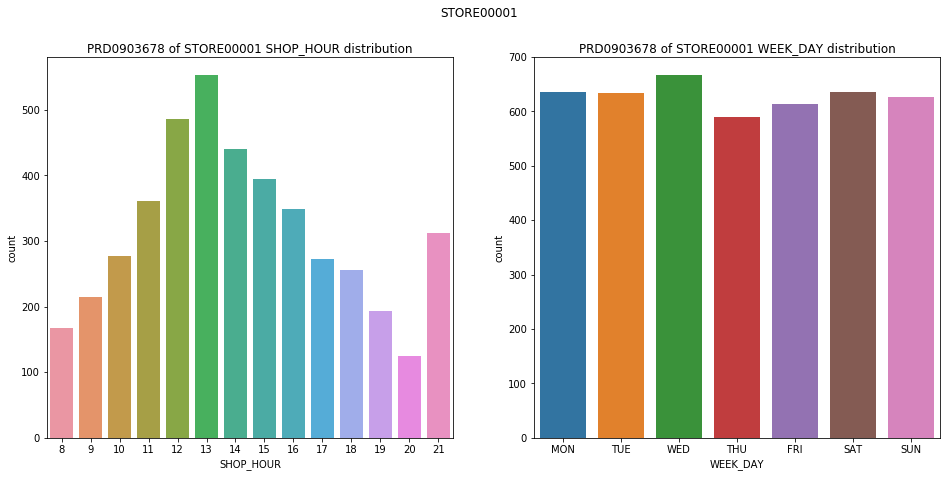

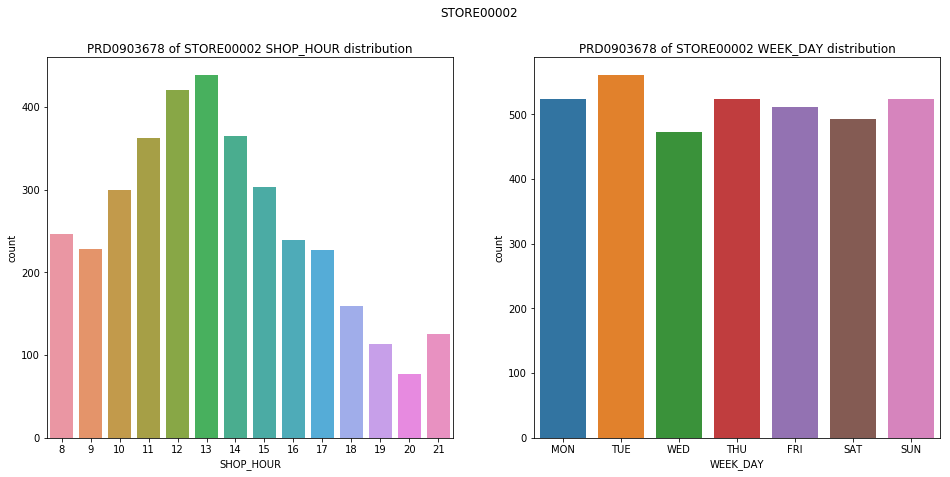

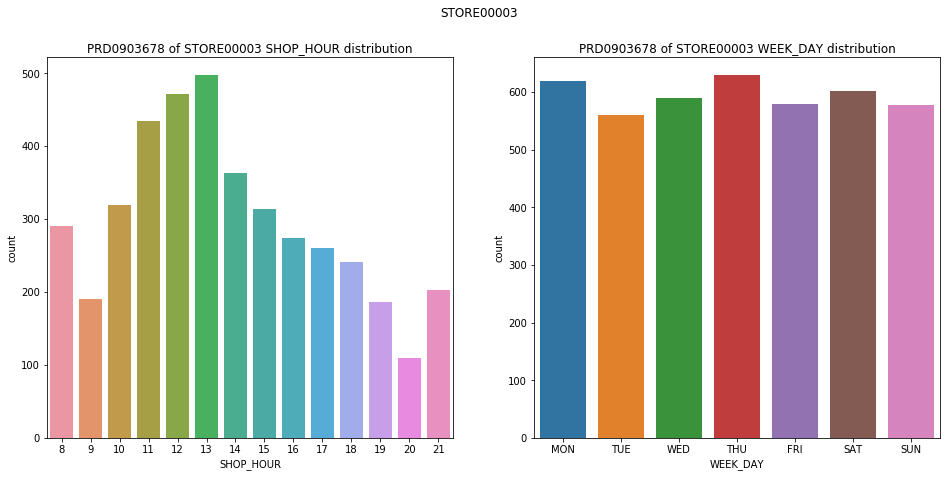

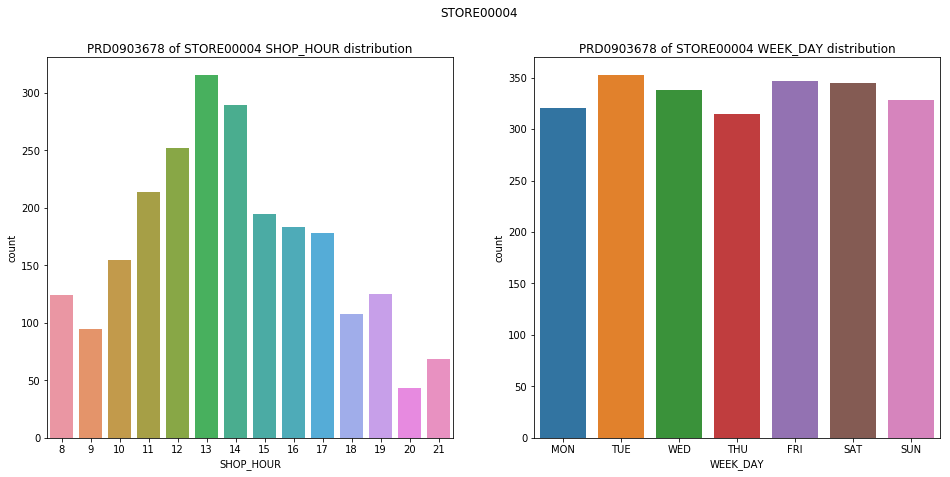

In [19]:
for store_code in shoppings['STORE_CODE'].unique():
    plot_top_product_by_time(store_code)

In [20]:
groupby_shop_hour = shoppings.groupby(['STORE_CODE', 'SHOP_HOUR'], as_index=False).agg({
    'BASKET_ID' : lambda x: len(x.unique())
})

shoppings['WEEK_DAY'] = shoppings['SHOP_DATE'].apply(lambda x: map_to_weekday(x.weekday()))

groupby_week_day = shoppings.groupby(['STORE_CODE', 'WEEK_DAY'], as_index=False).agg({
    'BASKET_ID' : lambda x: len(x.unique())
})

def plot_number_basket_sold(store_code):
    week_day_order = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
    
    total_baseket_by_shop_hour = groupby_shop_hour.loc[groupby_shop_hour['STORE_CODE'] == store_code, :]
    total_baseket_by_week_days = groupby_week_day.loc[groupby_week_day['STORE_CODE'] == store_code, :]
    
    plt.figure(figsize=(16, 6))
    plt.gcf().suptitle(store_code)
    
    plt.subplot(121)
    sns.barplot(data=total_baseket_by_shop_hour, x='SHOP_HOUR', y='BASKET_ID', order=total_baseket_by_shop_hour['SHOP_HOUR'])
    plt.ylabel('Total Basekets sold')
    
    plt.subplot(122)
    sns.barplot(data=total_baseket_by_week_days, x='WEEK_DAY', y='BASKET_ID', order=week_day_order)
    plt.show()

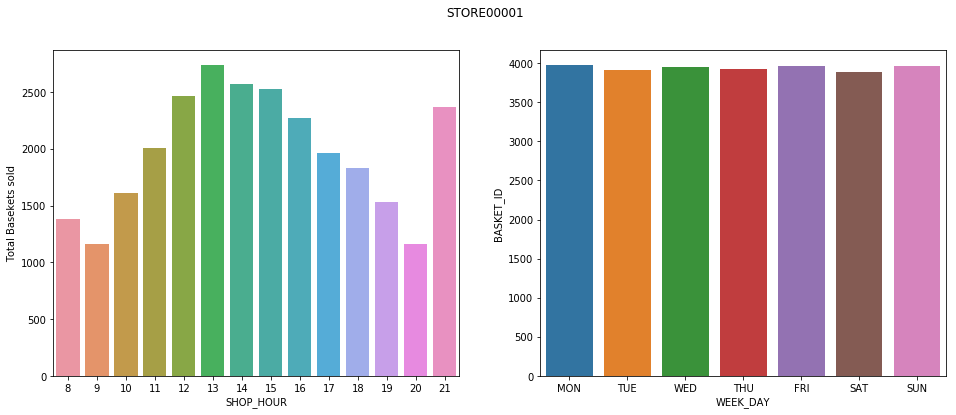

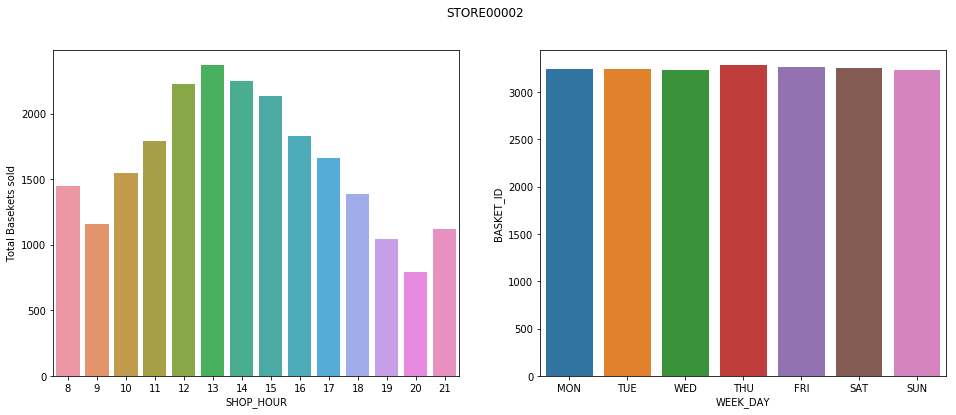

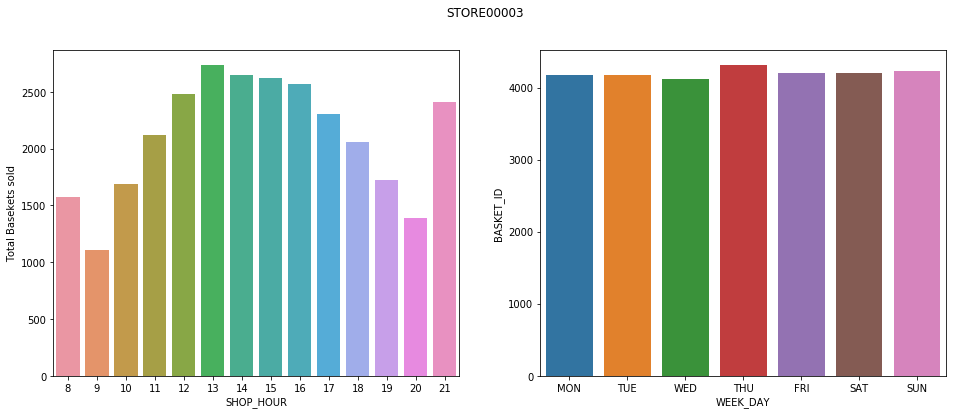

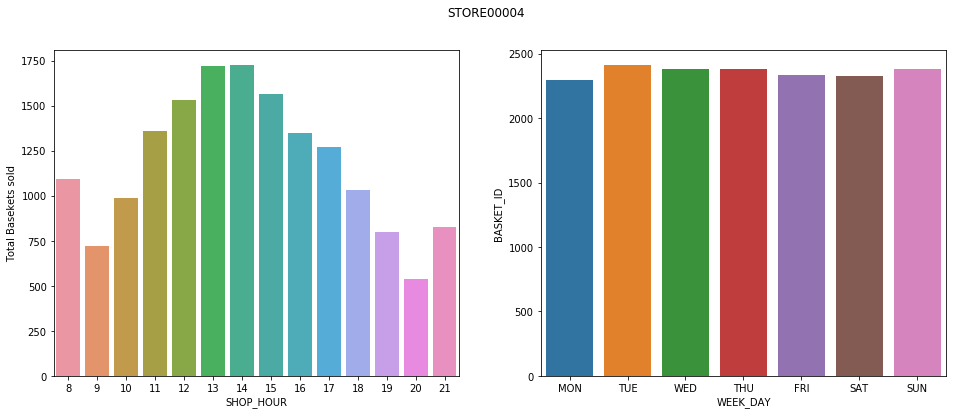

In [21]:
for store_code in shoppings['STORE_CODE'].unique():
    plot_number_basket_sold(store_code)